In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import r2_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("ticks", {'axes.grid': True})

In [2]:
RANDOM_STATE = 42

results_regression = pd.DataFrame(columns = ['model', 'task', 'R2'])
results_classification = pd.DataFrame(columns = ['model', 'task', 'f1', 'accuracy'])

def show_regression_results(exclude=[], df=results_regression):
    df = df.drop(df[df.model.isin(exclude)].index)
    plt.figure(figsize=(5, len(df) * 0.3))
    ax = sns.barplot(data=df, y='model', x='R2', palette='tab10')
    ax.set(xlim=(df.R2.min() * 0.99, df.R2.max() * 1.01))
    for i in ax.containers:
        ax.bar_label(i, fmt='%.4f')

https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html

In [3]:
data = pd.read_csv('data/boston.csv')
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


1. Разделите выборку на обучающую и тестовую в отношении 80%/20%, предварительно выделив целевую переменную (колонка 'MEDV').

In [4]:
X = data.drop(columns='MEDV')
y = data.MEDV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

def fit_r2(model):
    model.fit(X_train, y_train)
    return r2_score(y_test, model.predict(X_test))

X_train.shape, y_train.shape, X_test.shape, y_test.shape 

((404, 13), (404,), (102, 13), (102,))

2. Обучите стандартную регрессию, а также Ridge и  Lasso с параметрами по умолчанию и выведите их R2 на тестовой выборке

In [5]:
lr = LinearRegression()
ridge = Ridge(random_state=RANDOM_STATE)
lasso = Lasso(random_state=RANDOM_STATE)

r2_lr = fit_r2(lr)
r2_ridge = fit_r2(ridge)
r2_lasso = fit_r2(lasso)
results_regression.loc[0] = ['LR', 'task2', r2_lr]
results_regression.loc[1] = ['Ridge', 'task2', r2_ridge]
results_regression.loc[2] = ['Lasso', 'task2', r2_lasso]

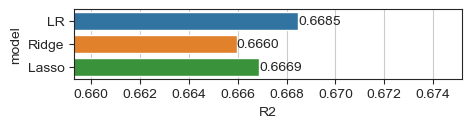

In [6]:
show_regression_results()

# Выводы:
# * качество моделей Ridge и Lasso хуже чем аналитичесое решение для линейной регрессии

3. Для Ridge и Lasso подберите коэффициент регуляризации двумя способами 1) GridSearchCV, 2) RidgeCV и LassoCV, в пределах от $10^{-5}$ до $10^5$ (по степеням 10). Посчитайте R2 на тестовой выборке по всем моделям и сравните с предыдущими результатами.

In [7]:
params_grid = {
    'alpha': np.logspace(-5, 5, 11)
}

ridge_grid = GridSearchCV(ridge, params_grid, scoring='r2')
ridge_cv = RidgeCV(alphas=params_grid['alpha'], scoring='r2')
lasso_grid = GridSearchCV(lasso, params_grid, scoring='r2')
lasso_cv = LassoCV(alphas=params_grid['alpha'], random_state=RANDOM_STATE)

r2_ridge_grid_search = fit_r2(ridge_grid)
r2_ridge_cv = fit_r2(ridge_cv)
r2_lasso_grid_search = fit_r2(lasso_grid)
r2_lasso_cv = fit_r2(lasso_cv)
results_regression.loc[3] = ['Ridge_GridSearchCV', 'task3', r2_ridge_grid_search]
results_regression.loc[4] = ['RidgeCV', 'task3', r2_ridge_cv]
results_regression.loc[5] = ['Lasso_GridSearchCV', 'task3', r2_lasso_grid_search]
results_regression.loc[6] = ['LassoCV', 'task3', r2_lasso_cv]

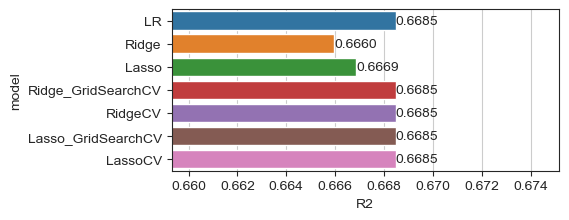

In [8]:
show_regression_results()

# Выводы:
# * с подобранными коэффициентами модели Ridge и Lasso догнали по качеству линейную регрессию

4. Проведите масштабирование выборки (используйте Pipeline, StandardScaler, MinMaxScaler), посчитайте R2 для Ridge и Lasso с параметрами по умолчанию и сравните с предыдущими результатами.

In [9]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

ridge_std = Pipeline([('scaler', std_scaler), ('model', ridge)])
ridge_mm = Pipeline([('scaler', mm_scaler), ('model', ridge)])
lasso_std = Pipeline([('scaler', std_scaler), ('model', lasso)])
lasso_mm = Pipeline([('scaler', mm_scaler), ('model', lasso)])

r2_ridge_standart_scaler = fit_r2(ridge_std)
r2_ridge_min_max_scaler = fit_r2(ridge_mm)
r2_lasso_standart_scaler = fit_r2(lasso_std)
r2_lasso_min_max_scaler = fit_r2(lasso_mm)
results_regression.loc[7] = ['Ridge_StandardScaler', 'task4', r2_ridge_standart_scaler]
results_regression.loc[8] = ['Ridge_MinMaxScaler', 'task4', r2_ridge_min_max_scaler]
results_regression.loc[9] = ['Lasso_StandardScaler', 'task4', r2_lasso_standart_scaler]
results_regression.loc[10] = ['Lasso_MinMaxScaler', 'task4', r2_lasso_min_max_scaler]

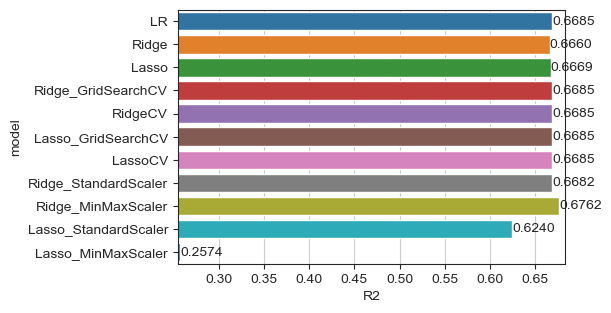

In [10]:
show_regression_results()

# Выводы:
# * оба варианта масштабирования для модели Lasso ухудшили качество (удалим их с диаграммы)

5. Подберите коэффициент регуляризации для Ridge и Lasso на масштабированных данных, посчитайте R2 и сравните с предыдущими результатами.

In [11]:
ridge_std_cv = Pipeline([('scaler', std_scaler), ('model', ridge_grid)])
ridge_mm_cv = Pipeline([('scaler', mm_scaler), ('model', ridge_grid)])
lasso_std_cv = Pipeline([('scaler', std_scaler), ('model', lasso_grid)])
lasso_mm_cv = Pipeline([('scaler', mm_scaler), ('model', lasso_grid)])

r2_ridge_standart_scaler_cv = fit_r2(ridge_std_cv)
r2_ridge_min_max_scaler_cv = fit_r2(ridge_mm_cv)
r2_lasso_standart_scaler_cv = fit_r2(lasso_std_cv)
r2_lasso_min_max_scaler_cv = fit_r2(lasso_mm_cv)
results_regression.loc[11] = ['Ridge_StandardScaler_CV', 'task5', r2_ridge_standart_scaler_cv]
results_regression.loc[12] = ['Ridge_MinMaxScaler_CV', 'task5', r2_ridge_min_max_scaler_cv]
results_regression.loc[13] = ['Lasso_StandardScaler_CV', 'task5', r2_lasso_standart_scaler_cv]
results_regression.loc[14] = ['Lasso_MinMaxScaler_CV', 'task5', r2_lasso_min_max_scaler_cv]

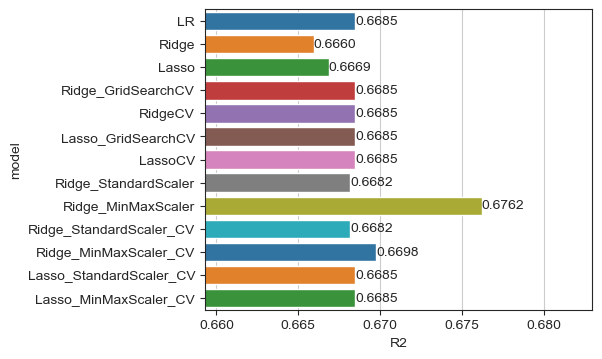

In [12]:
show_regression_results(['Lasso_MinMaxScaler', 'Lasso_StandardScaler'])

In [13]:
print(f'Ridge_MinMaxScaler: \talpha={ridge_mm[1].alpha}')
print(f'Ridge_MinMaxScaler_CV: \talpha={ridge_mm_cv[1].best_params_["alpha"]}')

# Выводы:
# * модель Lasso с масштабированием и подобранным коэффициентом регуляризации стала показывать результаты гораздо лучше
# * модель Ridge + MinMaxScaler с прошлого задания на кроссвалидации показала результат хуже,
#   но все еще держится в лидерах. По параметрам alpha видно, что на кроссвалидации было выбрано другое значение 
#   (вероятно высокий результат на прошлом шаге был случайностью, и на других данных модель показала бы результат хуже).
#   В дальнейшем удалим ее с диаграммы

Ridge_MinMaxScaler: 	alpha=1.0
Ridge_MinMaxScaler_CV: 	alpha=0.1


6. Добавьте попарные произведения признаков и их квадраты (используйте PolynomialFeatures) на масштабированных признаках, посчитайте R2 для Ridge и Lasso с параметрами по умолчанию и сравните с предыдущими результатами.

In [14]:
poly_comb = PolynomialFeatures(include_bias=False)

ridge_std_poly = Pipeline([('scaler', std_scaler), ('combiner', poly_comb), ('model', ridge)])
ridge_mm_poly = Pipeline([('scaler', mm_scaler), ('combiner', poly_comb), ('model', ridge)])
lasso_std_poly = Pipeline([('scaler', std_scaler), ('combiner', poly_comb), ('model', lasso)])
lasso_mm_poly = Pipeline([('scaler', mm_scaler), ('combiner', poly_comb), ('model', lasso)])

r2_ridge_standart_scaler_poly = fit_r2(ridge_std_poly)
r2_ridge_min_max_scaler_poly = fit_r2(ridge_mm_poly)
r2_lasso_standart_scaler_poly = fit_r2(lasso_std_poly)
r2_lasso_min_max_scaler_poly = fit_r2(lasso_mm_poly)
results_regression.loc[15] = ['Ridge_StandardScaler_Poly', 'task6', r2_ridge_standart_scaler_poly]
results_regression.loc[16] = ['Ridge_MinMaxScaler_Poly', 'task6', r2_ridge_min_max_scaler_poly]
results_regression.loc[17] = ['Lasso_StandardScaler_Poly', 'task6', r2_lasso_standart_scaler_poly]
results_regression.loc[18] = ['Lasso_MinMaxScaler_Poly', 'task6', r2_lasso_min_max_scaler_poly]

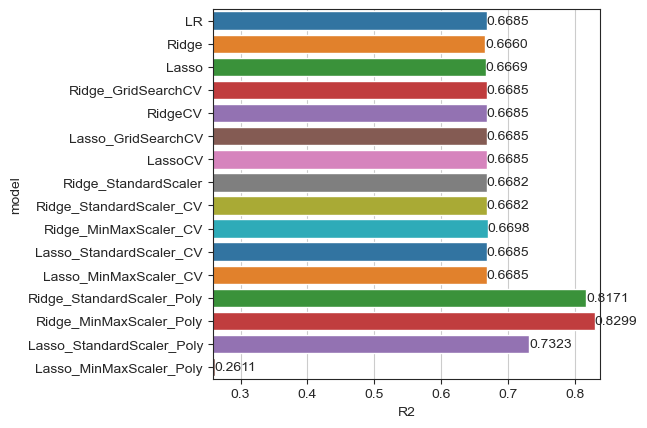

In [15]:
show_regression_results(['Lasso_MinMaxScaler', 'Lasso_StandardScaler', 'Ridge_MinMaxScaler'])

# Выводы:
# * добавление попарных произведений для Lasso + MinMaxScaler не улучшило ситуацию, очень низкое качество
#   (также удалим эту модель с диаграммы)
# * для остальных моделей комбинации признаков дали значительный прирост качества, особенно для Ridge
#   (интрига: просядет ли качество на кроссвалидации?)

7. Подберите коэффициент регуляризации для Ridge и Lasso на масштабированных данных, добавив PolynomialFeatures, посчитайте R2 и сравните с предыдущими результатами.

In [16]:
ridge_std_poly_cv = Pipeline([('scaler', std_scaler), ('combiner', poly_comb), ('model', ridge_grid)])
ridge_mm_poly_cv = Pipeline([('scaler', mm_scaler), ('combiner', poly_comb), ('model', ridge_grid)])
lasso_std_poly_cv = Pipeline([('scaler', std_scaler), ('combiner', poly_comb), ('model', lasso_grid)])
lasso_mm_poly_cv = Pipeline([('scaler', mm_scaler), ('combiner', poly_comb), ('model', lasso_grid)])

r2_ridge_standart_scaler_poly_cv = fit_r2(ridge_std_poly_cv)
r2_ridge_min_max_scaler_poly_cv = fit_r2(ridge_mm_poly_cv)
r2_lasso_standart_scaler_poly_cv = fit_r2(lasso_std_poly_cv)
r2_lasso_min_max_scaler_poly_cv = fit_r2(lasso_mm_poly_cv)
results_regression.loc[19] = ['Ridge_StandardScaler_Poly_CV', 'task7', r2_ridge_standart_scaler_poly_cv]
results_regression.loc[20] = ['Ridge_MinMaxScaler_Poly_CV', 'task7', r2_ridge_min_max_scaler_poly_cv]
results_regression.loc[21] = ['Lasso_StandardScaler_Poly_CV', 'task7', r2_lasso_standart_scaler_poly_cv]
results_regression.loc[22] = ['Lasso_MinMaxScaler_Poly_CV', 'task7', r2_lasso_min_max_scaler_poly_cv]

/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.156e+02, tolerance: 2.882e+00
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.170e+02, tolerance: 2.764e+00
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.186e+02, tolerance: 2.882e+00
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.147e+02, tolerance: 2.764e+00
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

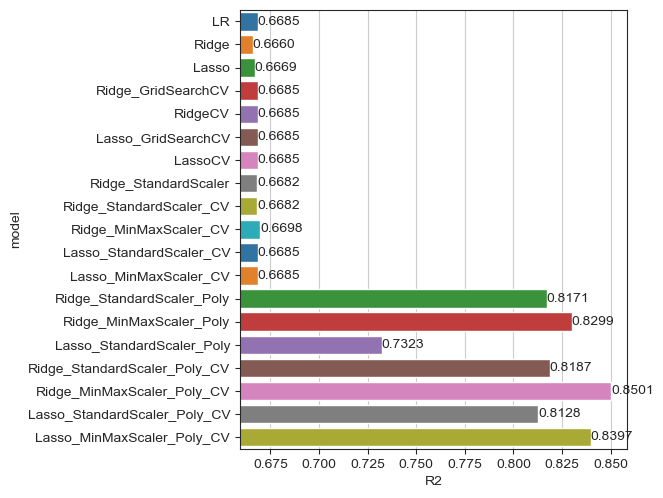

In [17]:
show_regression_results(['Lasso_MinMaxScaler', 'Lasso_StandardScaler', 'Ridge_MinMaxScaler', 'Lasso_MinMaxScaler_Poly'])

# Замечание:
#  * warnings для lasso, вероятно, вызваны особенностями loss-функции: 
#    * у MSE вблизи минимума производная уменьшается, что уменьшает шаг градиентного спуска 
#      и позволяет ближе подойти к оптимуму; 
#    * у MAE производная константа на всей области определения и, возможно, это заставляет прыгать вокруг оптимума,
#      не позволяя приблизиться к нему

# Выводы:
# * качество на кроссвалидации в этот раз улучшилось, причем модель с самой худшей конфигурацией Lasso + MinMaxScaler + Poly
#   оказалась на 2-м месте
# * обе модели (Ridge и Lasso) с масштабированием StandardScaler показали результат хуже, чем с MinMaxScaler

8. Подберите наилучшую модель (используйте Pipeline, GridSearchSCV) подбирая тип регуляризации (L1,L2), коэффициент регуляризации, метод масштабирования и степень полинома в PolynomialFeatures. Выведите итоговые параметры и результат R2.

In [18]:
pipe = Pipeline([
    ('scaler', None),
    ('combiner', PolynomialFeatures(include_bias=False)),
    ('model', None)
])

params_grid = {
    'scaler': [MinMaxScaler(), StandardScaler()],
    'combiner__degree': [1, 2],
    'model': [Ridge(), Lasso()],
    'model__random_state': [RANDOM_STATE],
    'model__alpha': np.logspace(-5, 5, 11),
}

best_grid = GridSearchCV(pipe, params_grid, scoring='r2')

r2_best_model = fit_r2(best_grid)
best_params = best_grid.best_params_
results_regression.loc[23] = ['Best_Model', 'task8', r2_best_model]

/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.008e+02, tolerance: 2.882e+00
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.265e+02, tolerance: 2.764e+00
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.045e+00, tolerance: 2.764e+00
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.744e+01, tolerance: 2.710e+00
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

In [19]:
print('Параметры лучшей модели:\n', best_params)

Параметры лучшей модели:
 {'combiner__degree': 2, 'model': Ridge(alpha=0.1, random_state=42), 'model__alpha': 0.1, 'model__random_state': 42, 'scaler': MinMaxScaler()}


In [20]:
results_regression

,model,task,R2
0,LR,task2,0.668483
1,Ridge,task2,0.665961
2,Lasso,task2,0.666869
3,Ridge_GridSearchCV,task3,0.668483
4,RidgeCV,task3,0.668474
5,Lasso_GridSearchCV,task3,0.668483
6,LassoCV,task3,0.668483
7,Ridge_StandardScaler,task4,0.668190
8,Ridge_MinMaxScaler,task4,0.676221
9,Lasso_StandardScaler,task4,0.624045


http://archive.ics.uci.edu/ml/datasets/Adult

In [21]:
data = pd.read_csv('data/adult.csv')
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


9. Разделите выборку на признаки и целевую переменную(колонка class). Замените целевую переменную на числовые значения ('<=50K' - 1, '>50K' - 0).

In [22]:
X = data.drop(columns='class')
y = data['class'].map({'<=50K': 1, '>50K': 0})

10. Посчитайте метрики accuracy и f1_score на предсказании только самого частого класса в целевой переменной.

In [23]:
most_freq_cls = y.value_counts().index[0]
y_pred_most_freq = np.full_like(y, most_freq_cls)

f1_most_frequent = f1_score(y, y_pred_most_freq)
acc_most_frequent = accuracy_score(y, y_pred_most_freq)
results_classification.loc[0] = ['Most Frequent class', 'task10', f1_most_frequent, acc_most_frequent]

11. Выясните, присутствуют ли в данных пропуски. Если присутствуют, заполните их самыми частыми значениями (испольуйте SimpleImputer)

In [24]:
X.info()

# описание данных говорит, что null-значений нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
dtypes: int64(6), object(8)
memory usage: 5.2+ MB


### числовые признаки

In [25]:
X.select_dtypes('number').describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [26]:
# подозрение вызывает колонка `capital-gain` с max значением 99999

print(X['capital-gain'].value_counts().sort_index(ascending=False).head())

# видно, что значения `99999` выделяются. Будем считать их пропусками

99999    244
41310      3
34095      6
27828     58
25236     14
Name: capital-gain, dtype: int64


### категориальные признаки

In [27]:
# посмотрим на категориальные признаки

X.select_dtypes('object').describe()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
count,48842,48842,48842,48842,48842,48842,48842,48842
unique,9,16,7,15,6,5,2,42
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
freq,33906,15784,22379,6172,19716,41762,32650,43832


In [28]:
print(X['workclass'].unique())

# В колонке есть пропущенные значения `?`

['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked']


In [29]:
X['education'].unique()

# В колонке нет пропусков

array(['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
       'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
       '5th-6th', '10th', '1st-4th', 'Preschool', '12th'], dtype=object)

In [30]:
X['marital-status'].unique()

# В колонке нет пропусков

array(['Never-married', 'Married-civ-spouse', 'Divorced',
       'Married-spouse-absent', 'Separated', 'Married-AF-spouse',
       'Widowed'], dtype=object)

In [31]:
print(X['occupation'].unique())

# В колонке есть пропущенные значения `?`

['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']


In [32]:
X['relationship'].unique()

# В колонке нет пропусков

array(['Not-in-family', 'Husband', 'Wife', 'Own-child', 'Unmarried',
       'Other-relative'], dtype=object)

In [33]:
X['race'].unique()

# В колонке нет пропусков

array(['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo',
       'Other'], dtype=object)

In [34]:
X['sex'].unique()

# В колонке нет пропусков

array(['Male', 'Female'], dtype=object)

In [35]:
X['native-country'].unique()

# В колонке есть пропущенные значения `?`

array(['United-States', 'Cuba', 'Jamaica', 'India', '?', 'Mexico',
       'South', 'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany',
       'Iran', 'Philippines', 'Italy', 'Poland', 'Columbia', 'Cambodia',
       'Thailand', 'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
       'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
       'China', 'Japan', 'Yugoslavia', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago',
       'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary',
       'Holand-Netherlands'], dtype=object)

In [36]:
# пропущенными значениями в категориальных колонках являются только значения `?`

### замена пропусков на моду

In [37]:
si = Pipeline([
    ('num', SimpleImputer(missing_values=99999, strategy='most_frequent')),
    ('cat', SimpleImputer(missing_values='?', strategy='most_frequent'))
])
si.fit(X)

X2 = pd.DataFrame(si.transform(X), columns=X.columns).convert_dtypes(convert_string=False)
((X2 == 99999) | (X2 == '?')).sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
dtype: int64

12. Выберите колонки с числовыми и категориальными переменными (используя возможности pandas).

In [38]:
num_cols = X.select_dtypes('number').columns.values
cat_cols = X.select_dtypes('object').columns.values

print('Numeric columns:', num_cols)
print('Categorical columns:', cat_cols)

Numeric columns: ['age' 'fnlwgt' 'education-num' 'capital-gain' 'capital-loss'
 'hours-per-week']
Categorical columns: ['workclass' 'education' 'marital-status' 'occupation' 'relationship'
 'race' 'sex' 'native-country']


13. Создайте пайплайн по обработке числовых и категориальных значений колонок (используйте OneHotEncoder,MinMaxScaler) и посчитайте cross_val_score по алгоритмам LogisticRegression, KNeighborsClassifier, LinearSVC по метрикам accuracy и f1_score.

In [39]:
def clf_cv_score(pipe_steps, metric, X, y):
    return cross_val_score(Pipeline(pipe_steps), X, y, scoring=metric, n_jobs=4).mean()

trans = ColumnTransformer([
    ('num', MinMaxScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
])

In [40]:
lr = LogisticRegression(max_iter=300)
knn = KNeighborsClassifier()
svm = LinearSVC()

In [41]:
f1_LR = clf_cv_score([('trans', trans), ('model', lr)], 'f1', X, y)
acc_LR = clf_cv_score([('trans', trans), ('model', lr)], 'accuracy', X, y)
f1_KNN = clf_cv_score([('trans', trans), ('model', knn)], 'f1', X, y)
acc_KNN = clf_cv_score([('trans', trans), ('model', knn)], 'accuracy', X, y)
f1_SVM = clf_cv_score([('trans', trans), ('model', svm)], 'f1', X, y)
acc_SVM = clf_cv_score([('trans', trans), ('model', svm)], 'accuracy', X, y)
results_classification.loc[1] = ['LogisticRegression', 'task13', f1_LR, acc_LR]
results_classification.loc[2] = ['KNeighborsClassifier', 'task13', f1_KNN, acc_KNN]
results_classification.loc[3] = ['LinearSVC', 'task13', f1_SVM, acc_SVM]

/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will b

In [42]:
# warning возникает из-за редкого значения в категориальной колонке `native-country`: значение `Holand-Netherlands` 
# встречается всего 1 раз. При делении на группы оно может попасть в валидационую выборку и сломать OneHotEncoder.
# Неплохой стратегией было бы заменить его на пропуск

14. Можно заметить что в данных присутствуют значения '?', замените их самыми частыми значениями, (испольуйте SimpleImputer). Посчитайте cross_val_score по алгоритмам LogisticRegression, KNeighborsClassifier, LinearSVC по метрикам accuracy и f1_score.

In [43]:
si = SimpleImputer(missing_values='?', strategy='most_frequent')
si.fit(X)

X_imp = pd.DataFrame(si.transform(X), columns=X.columns).convert_dtypes(convert_string=False)

In [44]:
f1_LR = clf_cv_score([('trans', trans), ('model', lr)], 'f1', X_imp, y)
acc_LR = clf_cv_score([('trans', trans), ('model', lr)], 'accuracy', X_imp, y)
f1_KNN = clf_cv_score([('trans', trans), ('model', knn)], 'f1', X_imp, y)
acc_KNN = clf_cv_score([('trans', trans), ('model', knn)], 'accuracy', X_imp, y)
f1_SVM = clf_cv_score([('trans', trans), ('model', svm)], 'f1', X_imp, y)
acc_SVM = clf_cv_score([('trans', trans), ('model', svm)], 'accuracy', X_imp, y)
results_classification.loc[4] = ['LogisticRegression_impute', 'task14', f1_LR, acc_LR]
results_classification.loc[5] = ['KNeighborsClassifier_impute', 'task14', f1_KNN, acc_KNN]
results_classification.loc[6] = ['LinearSVC_impute', 'task14', f1_SVM, acc_SVM]

/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will b

15. Посчитайте cross_val_score по тем же алгоритмам и метрикам, если просто удалить значения '?'.

In [45]:
X_drop = X.where(X != '?', np.nan).dropna()
y_drop = y.loc[X_drop.index]

In [46]:
f1_LR_del_missings = clf_cv_score([('trans', trans), ('model', lr)], 'f1', X_drop, y_drop)
acc_LR_del_missings = clf_cv_score([('trans', trans), ('model', lr)], 'accuracy', X_drop, y_drop)
f1_KNN_del_missings = clf_cv_score([('trans', trans), ('model', knn)], 'f1', X_drop, y_drop)
acc_KNN_del_missings = clf_cv_score([('trans', trans), ('model', knn)], 'accuracy', X_drop, y_drop)
f1_SVM_del_missings = clf_cv_score([('trans', trans), ('model', svm)], 'f1', X_drop, y_drop)
acc_SVM_del_missings = clf_cv_score([('trans', trans), ('model', svm)], 'accuracy', X_drop, y_drop)

results_classification.loc[7] = ['LogisticRegression_delete_missings', 'task15', f1_LR_del_missings, acc_LR_del_missings]
results_classification.loc[8] = ['KNeighborsClassifier_delete_missings', 'task15', f1_KNN_del_missings, acc_KNN_del_missings]
results_classification.loc[9] = ['LinearSVC_delete_missings', 'task15', f1_SVM_del_missings, acc_SVM_del_missings]

/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will b

In [47]:
results_classification

# Выводы:
# * для данного датасета замена пропусков на моду и удаление пропусков ухудшают результаты f1 и accuracy

,model,task,f1,accuracy
0,Most Frequent class,task10,0.864100,0.760718
1,LogisticRegression,task13,0.905011,0.851173
2,KNeighborsClassifier,task13,0.887002,0.824495
3,LinearSVC,task13,0.906251,0.852811
4,LogisticRegression_impute,task14,0.904659,0.850477
5,KNeighborsClassifier_impute,task14,0.887154,0.824864
6,LinearSVC_impute,task14,0.905187,0.850887
7,LogisticRegression_delete_missings,task15,0.901190,0.846911
8,KNeighborsClassifier_delete_missings,task15,0.882620,0.819999
9,LinearSVC_delete_missings,task15,0.902399,0.848481


 16. Посчитайте cross_val_score для RandomForestClassifier,GradientBoostingClassifier на данных с замененными значениями '?' на самые частые значения.

In [48]:
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()

In [49]:
f1_RF = clf_cv_score([('trans', trans), ('model', rf)], 'f1', X_imp, y)
acc_RF = clf_cv_score([('trans', trans), ('model', rf)], 'accuracy', X_imp, y)
f1_GB = clf_cv_score([('trans', trans), ('model', gb)], 'f1', X_imp, y)
acc_GB = clf_cv_score([('trans', trans), ('model', gb)], 'accuracy', X_imp, y)
results_classification.loc[10] = ['RandomForestClassifier', 'task16', f1_RF, acc_RF]
results_classification.loc[11] = ['GradientBoostingClassifier', 'task16', f1_GB, acc_GB]

/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will b

17. Подберите наилучшую модель, подбирая методы обработки колонок - масштабирование признаков, кодирование признаков и заполнение пропусков. Параметры алгоритмов оставьте по умолчанию. Выведите итоговые параметры и результат accuracy и f1_score.

In [50]:
num_imput = SimpleImputer(missing_values=99999, strategy='most_frequent')
cat_imput = SimpleImputer(missing_values='?', strategy='most_frequent')
dmy_imput = FunctionTransformer()

num_prep = Pipeline([
    ('impute', None), 
    ('scale', None)
])
cat_prep = Pipeline([
    ('impute', None), 
    ('encode', OneHotEncoder(drop='first', handle_unknown='ignore'))
])
preproc = ColumnTransformer([
    ('num', num_prep, num_cols), 
    ('cat', cat_prep, cat_cols)
])

pipe = Pipeline([
    ('preproc', preproc),
    ('model', None)
])

params_grid = {
    'model': [lr, knn, svm, rf, gb],
    'preproc__num__impute': [dmy_imput, num_imput],
    'preproc__num__scale': [MinMaxScaler(), StandardScaler()],
    'preproc__cat__impute': [dmy_imput, cat_imput],
}

In [51]:
best_grid_f1 = GridSearchCV(pipe, params_grid, scoring='f1', n_jobs=4).fit(X, y);

/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will b

/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWar

In [52]:
best_grid_acc = GridSearchCV(pipe, params_grid, scoring='accuracy', n_jobs=4).fit(X, y);

/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will b

/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWar

In [53]:
best_params_f1 = best_grid_f1.best_params_
best_params_acc = best_grid_acc.best_params_
print('Параметры лучшей модели (f1):\n', best_params_f1)
print('Параметры лучшей модели (accuracy):\n', best_params_acc)
f1_best = best_grid_f1.score(X, y)
acc_best = best_grid_acc.score(X, y)
results_classification.loc[12] = ['Best_Model', 'task17', f1_best, acc_best]

Параметры лучшей модели (f1):
 {'model': GradientBoostingClassifier(), 'preproc__cat__impute': FunctionTransformer(), 'preproc__num__impute': FunctionTransformer(), 'preproc__num__scale': MinMaxScaler()}
Параметры лучшей модели (accuracy):
 {'model': GradientBoostingClassifier(), 'preproc__cat__impute': FunctionTransformer(), 'preproc__num__impute': FunctionTransformer(), 'preproc__num__scale': StandardScaler()}


In [54]:
results_classification

,model,task,f1,accuracy
0,Most Frequent class,task10,0.864100,0.760718
1,LogisticRegression,task13,0.905011,0.851173
2,KNeighborsClassifier,task13,0.887002,0.824495
3,LinearSVC,task13,0.906251,0.852811
4,LogisticRegression_impute,task14,0.904659,0.850477
5,KNeighborsClassifier_impute,task14,0.887154,0.824864
6,LinearSVC_impute,task14,0.905187,0.850887
7,LogisticRegression_delete_missings,task15,0.901190,0.846911
8,KNeighborsClassifier_delete_missings,task15,0.882620,0.819999
9,LinearSVC_delete_missings,task15,0.902399,0.848481


In [55]:
# Выводы:
# * градиентный бустинг без заполнения пропусков модой справился с задачей лучше чем с заполнением
#   и, ожидаемо, стал лучшим алгоритмом